# Exploring sea ice heights with ICESat-2 (ATL07)
Author: Alek Petty (June 2019)    
Description: Notebook describing the ICESat-2 ATL07 product.   
Input requirements: Demo ATL07 data file

## Notebook objectives
* General understanding of what's included in a typical ATL07 file.
* Plotting and basic analysis of ATL07 data.
* Potentially some info on reading in and analyzing a large quantity of ATL07 data!

## Things to add to the notebook (need to get this done ASAP!)

* Add some stuff on the filename convention (e.g. Fernando's notebook)
* provide some omre info on the variables of interest.
* Explore the ssh_flag and quality flags. Highlight issues of cloud filtering etc. 
* Analyze the various beams! Show the consistency between strong and weak etc.
* Do a freeboard derivation! Show how we go from ATL07 to ATL10. 
* Maybe work backwards from the included data to derive elevation using ATL03 and the various ancillary products (geoid, tides, atmospheric corrections etc).
* Do some large scale processing reading in a load of ATL07 files.

## Background
ICESat-2 carries onboard a single instrument – the Advanced Topographic Laser Altimeter System, or ATLAS. Like the altimeter on the first ICESat mission, ATLAS measures the travel times of laser pulses to calculate the distance between the spacecraft and Earth’s surface. 

Something about ATL03...

ATL07 provides along-track surface height and type (e.g. snow-covered ice, open water) for the ice-covered seas of the northern and southern hemispheres. Sea surface and sea ice height are estimated for segments along each of the six ground tracks. Segment length varies with surface type, determined by the distance over which ~100 signal photons are accumulated. Two files are provided per day, one each for the north and south, which contain the sixteen intra-day orbits broken out by hemisphere. Description courtesy NSIDC.   

Here I use the hdf5 file from: https://nsidc.org/data/atl07   
For the demo below I'm using the file: 'ATL07-01_20181115003141_07240101_001_01.h5'

Sea ice products of interest:   
ATL03: Along-track photon cloud elevations  
ATL07: Along-track segment heights (this notebook!!)   
ATL10: Along-track freeboards

### Notes   
* The segment length is expected to change from 100 to 150 photons.   
* Check out the known issues document for more things to look out for:https://nsidc.org/sites/nsidc.org/files/technical-references/ATL0710-KnownIssues.pdf



# Instructions
1. Follow along with the notebook tutorial. 
2. Play around changing options and re-running the relevant notebook cells. 

In [131]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [132]:
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import convert_GPS_time as cGPS
import seaborn as sns
import pandas as pd
import h5py  

In [133]:
# Use seasborn for nicer looking inline plots
sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")

file_path = './'
ATL07_filename = 'ATL07-01_20181115003141_07240101_001_01.h5'
ATL07_file_path = file_path + ATL07_filename
beamStr='gt1r'

In [134]:
# add an option if you want to spit out data as an array or a pandas dataframe.

def getATL07data(fileT, numpy=0, beam='gt1l', maxElev=1e6):
    # Add in a proper description of the function here
    
    
    # Open the file
    ATL07 = h5py.File(fileT, 'r')
    
    lons=ATL07[beam+'/sea_ice_segments/longitude'][:]
    lats=ATL07[beam+'/sea_ice_segments/latitude'][:]
    
    along_track_distance=ATL07[beam+'/sea_ice_segments/seg_dist_x'][:] # Along track distance from equator i think.
    
    delta_time=ATL07[beam+'/sea_ice_segments/delta_time'][:] #Number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    atlas_epoch=ATL07['/ancillary_data/atlas_sdp_gps_epoch'][:] #Add this value to delta time parameters to compute full gps_seconds

    #Test conversion of delta_time to a calendar date
    temp = cGPS.convert_GPS_time(atlas_epoch[0] + delta_time, OFFSET=0.0)

    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')


    # Primary variables of interest
    
    # Beam segment height
    elev=ATL07[beam+'/sea_ice_segments/heights/height_segment_height'][:]
    # Flag for potential leads, 0=sea ice, 1 = sea surface
    ssh_flag=ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] 
    # Height quality, 1 for good fit, 0 for bad
    quality=ATL07[beam+'/sea_ice_segments/heights/height_segment_quality'][:] 
    
    elev_rms = ATL07[beam+'/sea_ice_segments/heights/height_segment_rms'][:] #RMS difference between modeled and observed photon height distribution
    seg_length = ATL07[beam+'/sea_ice_segments/heights/height_segment_length_seg'][:] # Along track length of segment
    height_confidence = ATL07[beam+'/sea_ice_segments/heights/height_segment_confidence'][:] # Height segment confidence flag
    reflectance = ATL07[beam+'/sea_ice_segments/heights/height_segment_asr_calc'][:] # Apparent surface reflectance
    ssh_flag = ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] # Flag for potential leads, 0=sea ice, 1 = sea surface
    seg_type = ATL07[beam+'/sea_ice_segments/heights/height_segment_type'][:] # 0 = Cloud covered
    gauss_width = ATL07[beam+'/sea_ice_segments/heights/height_segment_w_gaussian'][:] # Width of Gaussian fit

    
    # Secondary variables of interest
    dac = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_dac'][:] # AVISO dynamic atmospheric correction
    earth = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_earth'][:] # Solid earth tide
    geoid = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_geoid'][:] # Geoid
    loadTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_load'][:] # Load tide
    mss = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_mss'][:] # Mean sea surface
    oceanTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_ocean'][:] # Ocean tide, Alternatively ocean_1l=hf['gt1l']['sea_ice_segments']['geophysical']['height_segment_ocean'][:]
    poleTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_pole'][:] # Pole tide

    ATL07.close()
    
    
    if (numpy==1):
        return along_track_dist, elev
    
    else:
        dF = pd.DataFrame({'elev':elev, 'lons':lons, 'lats':lats, 'ssh_flag':ssh_flag, 
                       'quality_flag':quality, 'delta_time':delta_time,'along_track_distance':along_track_distance, 'year':year, 'month':month, 'day':day, 'hour':hour, 'second':second},
                         columns=['elev','lons','lats', 'ssh_flag', 'quality_flag', 'delta_time', 'along_track_distance','year', 'month', 'day', 'hour', 'second'])
        
        # Filter out high elevation values 
        dF = dF[(dF['elev']<maxElev)]
        # Reset row indexing
        dF=dF.reset_index(drop=True)
        return dF



In [135]:
# Get data using numpy
#along_track_dist, elev=getATL07data(ATL07_file_path, numpy=1, beam=beamStr)
#good = np.where((elev < 100) )	#& (quality_1l == 1)
#along_track_dist=along_track_dist[good]
#elev=elev[good]
#plt.figure(figsize=(10, 5))
#plt.plot((along_track_dist-along_track_dist[0])/1000., elev)
#plt.xlabel('Along track distance (km)')
#plt.ylabel('Elevation (m)')
#plt.show()

# Get data using Pandas
dF07=getATL07data(ATL07_file_path, numpy=0, beam=beamStr)
dF07.head(10)


,elev,lons,lats,ssh_flag,quality_flag,delta_time,along_track_distance,year,month,day,hour,second
0,0.443309,-164.275288,59.864463,0,1,2.747804e+07,6.671127e+06,2018,11,15,0,18
1,0.439604,-164.275288,59.864463,0,1,2.747804e+07,6.671127e+06,2018,11,15,0,18
2,0.469707,-164.275327,59.864671,0,1,2.747804e+07,6.671150e+06,2018,11,15,0,18
3,0.422271,-164.275374,59.864914,0,1,2.747804e+07,6.671177e+06,2018,11,15,0,18
4,0.392907,-164.275425,59.865173,1,1,2.747804e+07,6.671207e+06,2018,11,15,0,18
5,0.463985,-164.275467,59.865382,0,1,2.747804e+07,6.671230e+06,2018,11,15,0,18
6,0.459417,-164.275525,59.865664,0,1,2.747804e+07,6.671262e+06,2018,11,15,0,18
7,0.406700,-164.275581,59.865928,1,1,2.747804e+07,6.671291e+06,2018,11,15,0,18
8,0.423204,-164.275631,59.866162,0,1,2.747804e+07,6.671317e+06,2018,11,15,0,18
9,0.486481,-164.275704,59.866502,0,1,2.747804e+07,6.671357e+06,2018,11,15,0,18


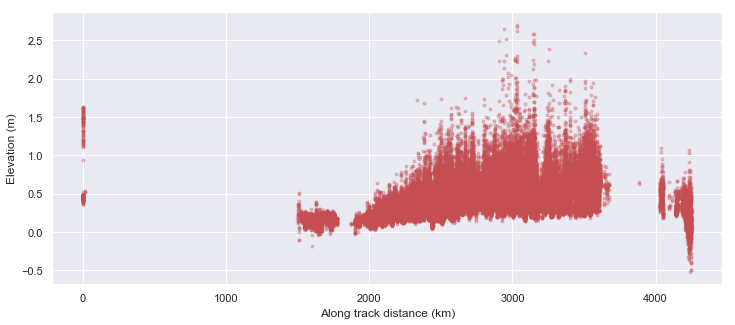

In [136]:
plt.figure(figsize=(12, 5))
plt.plot((dF07.along_track_distance-dF07.along_track_distance[0])/1000., dF07.elev, color='r', marker='.', linestyle='None', alpha=0.3)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()


In [137]:
# Do a groupby of the above data based on the ssh_flag. 
# Colour code the plot using the various calssifications. 
# e.g. 
dFstype=dF07.groupby('ssh_flag')
dFstype['elev'].agg(['mean', 'std', 'median', 'mad'])

,mean,std,median,mad
ssh_flag,,,,
0,0.398336,0.188262,0.36228,0.142645
1,0.146795,0.073265,0.12388,0.060434


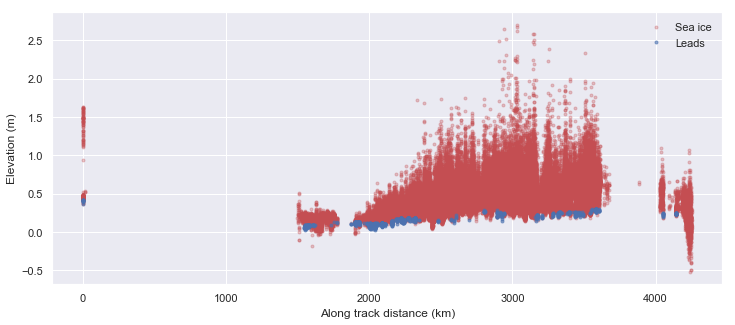

In [142]:
dFstypeIce=dFstype.get_group(0)
dFstypeLeads=dFstype.get_group(1)
plt.figure(figsize=(12, 5))
plt.plot((dFstypeIce.along_track_distance-dF07.along_track_distance[0])/1000., dFstypeIce.elev, color='r', marker='.', linestyle='None', label='Sea ice', alpha=0.3)
plt.plot((dFstypeLeads.along_track_distance-dF07.along_track_distance[0])/1000., dFstypeLeads.elev, color='b', marker='.', linestyle='None',label='Leads', alpha=0.6)
plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()

In [139]:
# Run some basic analysis of the sea surface and sea ice elevations

In [140]:
# The different beams have different number of dimensions. 
# How do we merge them into a joint array? 

#import xarray as xr
#xr.Dataset(dF)
#xr.Dataset(dF)
#xr.merge([dF, dF2], compat='no_conflicts')